# ESO Python Coffee - May 22, 2024
# (Short) Introdution to SHAP

### R. Carvajal (IA - FCUL, Portugal)

Shapley values (Shapley, 1953) are a method from coalitional game theory that tells us how to fairly distribute the dividends (the prediction in our case) among the features of a function (see a thorough description in its Wikipedia [article](https://en.wikipedia.org/wiki/Shapley_value)).

SHapley Additive exPlanations (SHAP, [documentation](https://shap.readthedocs.io/en/latest/) and [repository](https://github.com/shap/shap)) is a Python package that can obtain Shapley values (or a very good approximation) from general functions, including complex Machine Learning (ML) models.

These ML models are often treated as "black boxes" because their internal workings are difficult to understand. SHAP helps understanding them by revealing how each piece of data (a feature) influences the final prediction.

Contrary to other methods and packages, SHAP can extract information from individual predictions. This means we can go beyond understanding the overall importance of features and know how each prediction `moves' inside the function or model.

SHAP values (the output from SHAP) tell us how much each feature in a model (or other function) impacts its final predictions. They do this by comparing the actual model output to what the it would predict if that specific feature had a different value. Essentially, they calculate the difference between the prediction with a specific feature and the model's expected prediction without it.

In simpler terms, SHAP values show how much each feature "pushes" the model's prediction in a certain direction (positive or negative) compared to a baseline.  The higher the absolute SHAP value (positive or negative), the bigger the impact that feature has on the final prediction.

We will show two short examples of how to use and interpret SHAP values from simple functions.

First, we install and import all the packages we will need,

In [ ]:
# !pip install astropy
# !pip install shap

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from astropy.table import Table
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
import shap
import helper_functions as helpers  # own file with functions

### Function and data set-up

For our first example, we will use a polynomial and we will try to determine their strongest factors.

We will create a polynomial of degree 5 of the form:

$$ f(x) = 1.5 + x_{1} + 2 x_{2}^{2} - 3 x_{3}^{3} + 0.8 x_{4}^{4} - 0.5 x_{5}^{5}$$

with

$$x = (x_{0}, x_{1}, x_{2}, x_{3}, x_{4}, x_{5})$$

In [2]:
coeffs = [1.5, 1, 2, -3, 0.8, -0.5]
degree = 5
nelems = 10

We define that polynomial in Python

In [3]:
def func_pol(x):
  # x is a 5D vector
  # 1.5 + x1 + 2 x2^2 -3 x3^3 + 0.8 x4^4 - 0.5 x5^5
  pol = 0
  for count in np.arange(degree + 1):
    pol += coeffs[count] * x[:, count]**(count)
  return pol

We create the set of input values for our function, x.

In this case, random values bewtween $-2$ and $2$.

Also, and for clarity, we name each column (feature) of the dataset.

In [4]:
rng          = np.random.default_rng()
data_rand    = rng.uniform(low=-2, high=2, size=(nelems, degree + 1))
data_rand_df = pd.DataFrame(data_rand, columns=['Degree_0', 'Degree_1', 'Degree_2',
                                                'Degree_3', 'Degree_4', 'Degree_5'])
display(data_rand_df)

,Degree_0,Degree_1,Degree_2,Degree_3,Degree_4,Degree_5
0,-0.883200,-0.195378,-1.431508,0.607523,-1.806953,0.743087
1,-1.336807,0.989279,-0.931132,1.573787,-0.137441,0.153638
2,-1.258705,1.744202,0.882873,0.532568,0.104462,0.088536
3,0.115386,0.623099,0.909527,-0.191194,-0.121127,-1.239422
4,-1.550908,-1.673315,0.804354,-0.851598,-1.586169,-0.439302
5,0.200401,0.833908,-0.806646,-0.388101,-1.214233,0.975625
6,0.584236,0.902482,-0.088409,1.058589,1.198214,0.176337
7,-0.282412,0.185814,-1.120072,1.499696,-0.137658,-1.916660
8,0.612104,-1.727829,1.888411,-0.304894,-0.321097,1.504107
9,1.211477,0.366210,1.560567,-0.789582,0.290956,1.223247


Now, we can check their output values from our polynomial

In [5]:
func_pol(data_rand)

array([13.14568841, -7.47035452,  4.35007154,  5.26111803,  8.0455584 ,
        5.10766593,  0.50825996,  7.00925104,  3.14875876,  6.85002012])

In order to understand the impact of each element of the polynomial, we can plot how it behaves when all the elements of the vectors are zero ($0$) except that of the analysed degree.

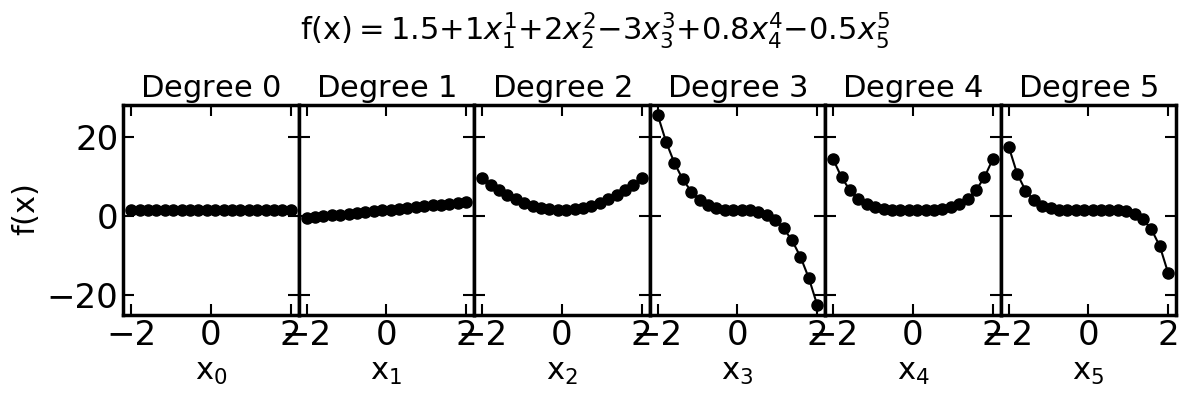

In [6]:
helpers.plot_polynomial_degrees(func_pol, coeffs=coeffs, degree=degree)

We can see, for instance, that the first-degree term remains constant regardless of the value of $x_{0}$.

Then, the remaining terms behave as we would expect times their coefficient. In this way, the term with the largest range of values is the third-degree factor (i.e. $[-25,25]$, even more than the fift-degree term).


### SHAP analysis

Now, we start our SHAP analysis. First, we need to create an `Explainer` object with our function and the data it uses for training (in a ML context). Some relevant attributes are:

- `expected_value`
- `shap_values()`


Then, we can apply that explainer to the data we want to explain. It will output an `Explanation` object with the following relevant attributes:

- `feature_names`
- `data`
- `base_values`
- `values`

`expected_value` will output the mean value of all predictions for our dataset. This value is used by SHAP to obtain their impact on the final predictions. Recall that SHAP values are relative to their base value.

`feature_names` outputs the name of the features used in our traininig (or background) data.

`base_values` will, by default, replicate the `expected_value` from the `Explainer` for each feature. But, these `base_values` can be modified as needed.

There are several types of `Explainer` objects. A full list is shown [here](https://shap.readthedocs.io/en/latest/api.html).

We have selected the `KernelExplainer`, which implements a linear regression for the computation of feature importances of any model and function.

In [7]:
explainer_func    = shap.KernelExplainer(func_pol, data_rand_df)
explanations_func = explainer_func(data_rand_df)
shap_values_func  = explanations_func.values

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
explainer_func.expected_value

4.595603766900827

In [9]:
explanations_func.feature_names

['Degree_0', 'Degree_1', 'Degree_2', 'Degree_3', 'Degree_4', 'Degree_5']

In [10]:
explanations_func.base_values

array([4.59560377, 4.59560377, 4.59560377, 4.59560377, 4.59560377,
       4.59560377, 4.59560377, 4.59560377, 4.59560377, 4.59560377])

From their theoretical definition, SHAP values are linear and can be combined and compared between them. For that reason, we are able to re-scale them to express the percentage of impact over the total prediction. We do this and also show the cumulative impact of all features.

In [11]:
helpers.tabular_shap_vals(explanations_func)

,Feature,Mean abs SHAP,Mean abs SHAP %,Cumulative sum %
0,Degree_3,3.701120,34.340465,34.340465
1,Degree_5,2.533875,23.510300,57.850765
2,Degree_4,2.046568,18.988871,76.839635
3,Degree_2,1.650141,15.310660,92.150296
4,Degree_1,0.846019,7.849704,100.000000
5,Degree_0,0.000000,0.000000,100.000000


From the analysis of the previous table, we can see that the most impactful factor is the third-degree coefficient (much more than the fift-degree element). Also, if we created a new polynomial, but without the first and zeroth-degree coefficient, the final results would be almost the same of the original function ($\sim 95 \%$).

The SHAP package implements several graphical tools for the analysis of their values.
We will start with the simplest plot.

The bar plot shows the mean absolute value of the SHAP values among the target dataset. These values are sorted by importance as to highlight their relative importance.

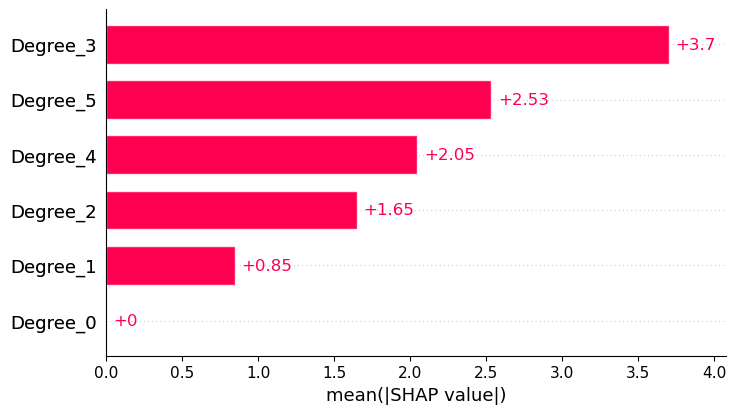

In [12]:
shap.plots.bar(shap_values=explanations_func,
                max_display=len(explanations_func.feature_names),
                show=True)

A second visualization is the Decision Plot. It shows how each data instance arrives to its final prediction or output after being fed to our target function or model.

The x-axis represents the model’s output. For a classification ML model, the units would be log odds. The plot is centered on the x-axis at `expected_value`. The y-axis lists the model’s features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. Each observation’s prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation’s predicted value. This value determines the color of the line on a spectrum. * Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model’s base value. This shows how each feature contributes to the overall prediction. * At the bottom of the plot, the observations converge at explainer.expected_value.

We create a decision plot for all the values in our dataset.

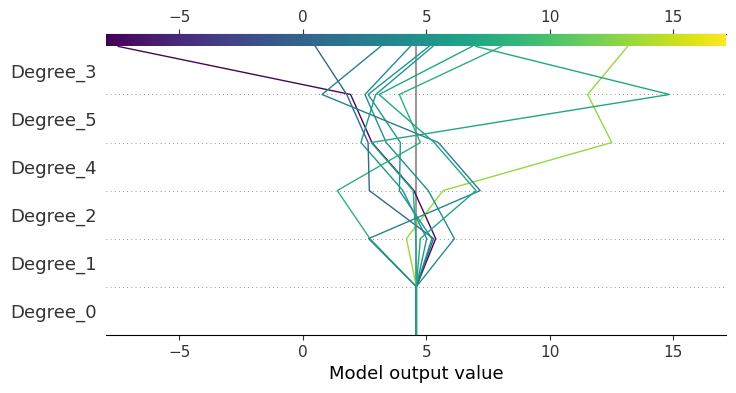

In [13]:
shap.decision_plot(explainer_func.expected_value,
                    shap_values_func,
                    data_rand_df,
                    plot_color='viridis')

We can see how relevant the third-degree term is for the final output. Also, we can notice the null impact of the zeroth-order factor.

It is also possible to create Decision Plots for each individual element of the dataset. We will do it for the three first element of our sample.

In each row, the plot shows the value of the selected element that goes into each coefficient. That is, the value of each feature.

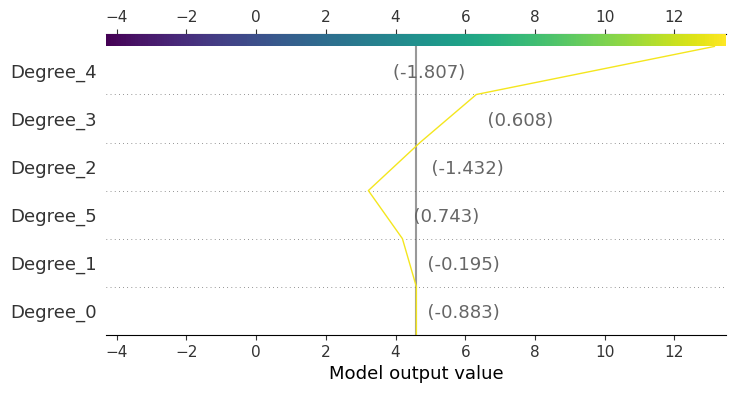

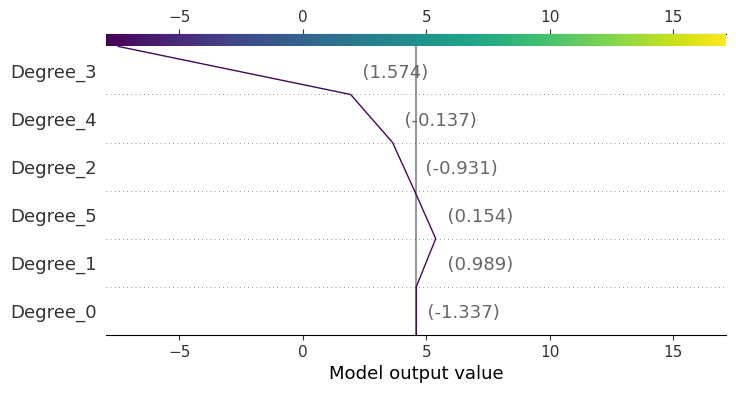

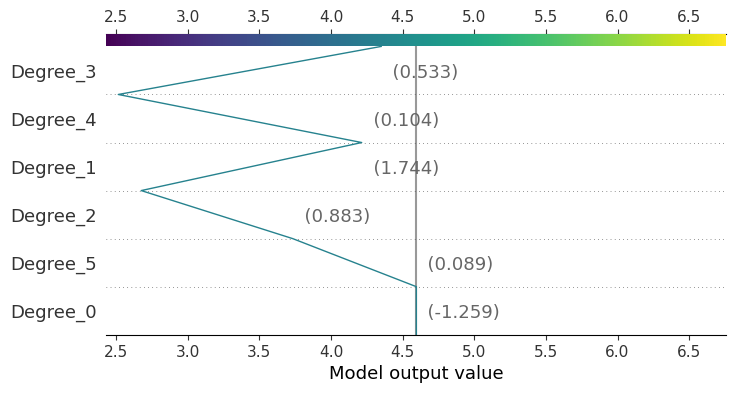

In [14]:
for count in np.arange(nelems)[:3]:
    shap.decision_plot(explainer_func.expected_value,
                        shap_values_func[count],
                        data_rand_df.loc[count],
                        plot_color='viridis')

The SHAP package can be used with regular functions, as in this example. It can also be applied to all sorts of ML models (random forests, image models, NNs, and more).

Additional plots are available to assess the impact of each feature in the final output of the studied functions and models.

## An Astronomical example: Redshift prediction in SDSS QSOs

Now, we will obtain SHAP values for a simple ML model that predicts redshift values for QSOs from the SDSS-DR16Q (Lyke et al. 2020) dataset with photometric measurements.

### Data set-up

We first load our data and select the relevant features: redshift, SDSS magnitudes, GALEX magnitudes, *WISE* magnitudes, 2MASS magnitudes, and *Gaia* proper motions.

In [15]:
SDSS_data_table = Table.read('./data/DR16Q_v4_measured_test.fits')
SDSS_data_table.info

<Table length=4733>
    name      dtype    unit  
------------ ------- --------
   SDSS_NAME bytes18         
     RA_SDSS float64      deg
    DEC_SDSS float64      deg
IS_QSO_FINAL   int16         
           Z float64         
    SOURCE_Z bytes12         
    ZWARNING   int32         
    PSFMAG_u float32      mag
    PSFMAG_g float32      mag
    PSFMAG_r float32      mag
    PSFMAG_i float32      mag
    PSFMAG_z float32      mag
         FUV float64  3.63uJy
         NUV float64  3.63uJy
     FUV_MAG float64      mag
     NUV_MAG float64      mag
      W1_MAG float32      mag
      W2_MAG float32      mag
        JMAG float64      mag
        HMAG float64      mag
        KMAG float64      mag
  GAIA_PM_RA float64 mas / yr
 GAIA_PM_DEC float64 mas / yr

In [16]:
cols_2_use_SDSS = ['Z', 'PSFMAG_u', 'PSFMAG_g', 'PSFMAG_r',
                    'PSFMAG_i', 'PSFMAG_z', 'FUV_MAG', 'NUV_MAG',
                    'W1_MAG', 'W2_MAG', 'JMAG', 'HMAG', 'KMAG',
                    'GAIA_PM_RA', 'GAIA_PM_DEC']
                    
SDSS_data_df = SDSS_data_table.to_pandas().loc[:, cols_2_use_SDSS]

Given the logarithmic nature of redshifts, we create a function for the comparison of true and predicted redshifts through their bias.

In [17]:
def bias_z(y_true, y_pred, **kwargs):
    num = np.abs(y_true - y_pred)
    den = 1 + y_true
    return np.nanmedian(num / den)

bias_z_scorer = make_scorer(score_func=bias_z, greater_is_better=False)

We reserve a $20\%$ of the dataset for testing the model's performance.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(SDSS_data_df.drop(columns=['Z'], inplace=False),
                                                    SDSS_data_df.loc[:, 'Z'],
                                                    test_size=0.20,
                                                    random_state=42)
print(np.shape(X_train))
print(np.shape(X_test))

(3786, 14)
(947, 14)


### Model creation, fitting, and scoring

We will use a Random Forest regressor for the prediction of redshifts. We create the object and train it.

In [19]:
regr_SDSS = RandomForestRegressor(max_depth=4, random_state=42, verbose=1)
regr_SDSS.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


RandomForestRegressor(max_depth=4, random_state=42, verbose=1)

Now, we want to know how well our predictions are in the test subset. We calculate, with cross-validation, the bias of the sample. 

In [32]:
test_scores_SDSS = -cross_val_score(regr_SDSS,
                                    X_test,
                                    y_test,
                                    cv=10,
                                    scoring=bias_z_scorer,
                                    verbose=0)

y_pred_test      = regr_SDSS.predict(X_test)

print('-'*30)
print(f'Testing bias is {np.nanmean(test_scores_SDSS):.3f} ± {np.nanstd(test_scores_SDSS):.3f}')
print('-'*30)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

------------------------------
Testing bias is 0.114 ± 0.010
------------------------------


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


We can also plot the predicted and true values to see the performance of the model on the test set.
The model could do better, but this is not our goal in this notebook.

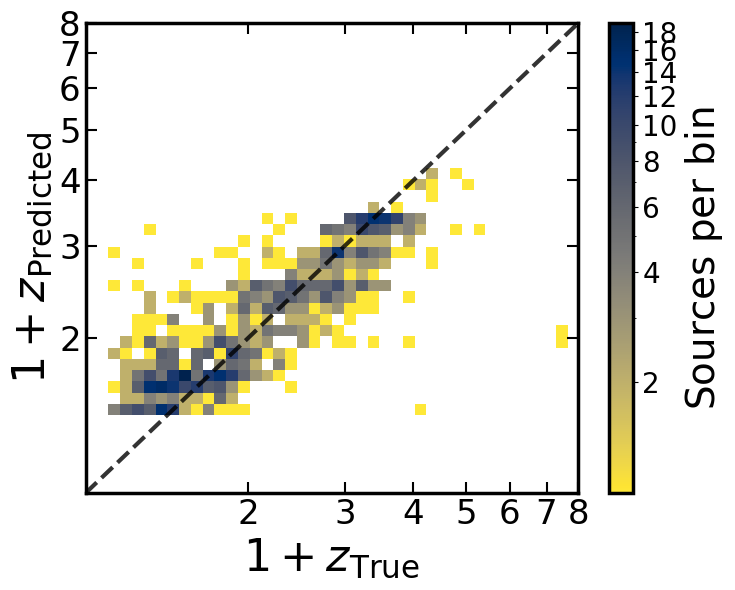

In [21]:
helpers.plot_redshifts(y_test, y_pred_test)

### SHAP analysis

We create all SHAP objects and values.

In [22]:
explainer_SDSS   = shap.TreeExplainer(regr_SDSS)
explanation_SDSS = explainer_SDSS(X_test)
shap_values_SDSS = explanation_SDSS.values

SHAP values can be re-scaled to be shown as percentages.

In [23]:
helpers.tabular_shap_vals(explanation_SDSS)

,Feature,Mean abs SHAP,Mean abs SHAP %,Cumulative sum %
0,W1_MAG,0.353231,39.189931,39.189931
1,FUV_MAG,0.140762,15.617165,54.807096
2,NUV_MAG,0.139903,15.521832,70.328928
3,PSFMAG_z,0.076214,8.455760,78.784688
4,PSFMAG_i,0.074275,8.240576,87.025264
5,W2_MAG,0.047396,5.258461,92.283724
6,PSFMAG_r,0.033399,3.705499,95.989223
7,PSFMAG_u,0.022334,2.477908,98.467131
8,KMAG,0.006709,0.744319,99.211450
9,PSFMAG_g,0.003328,0.369202,99.580652


Bar plot for mean absolute SHAP values of test subset.

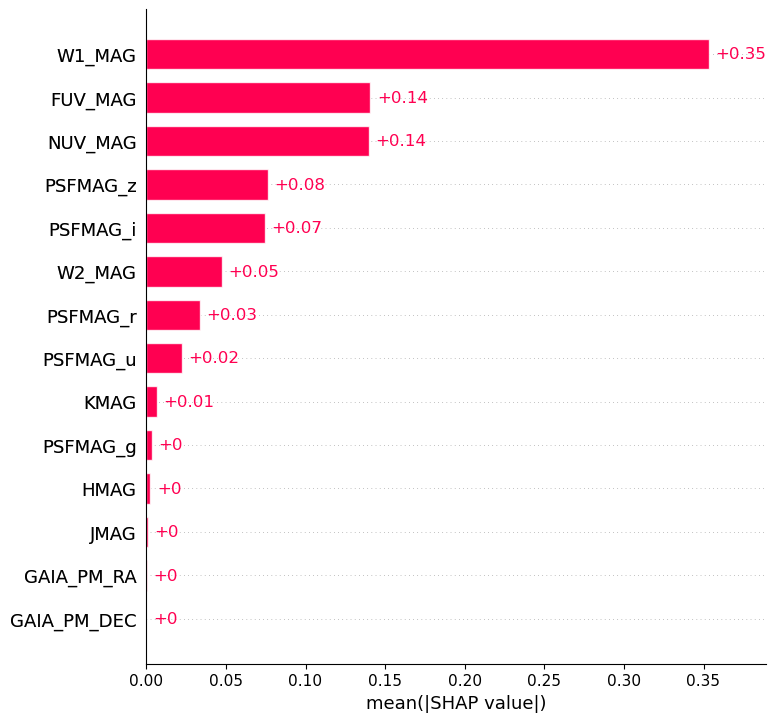

In [24]:
shap.plots.bar(shap_values=explanation_SDSS,
                max_display=len(explanation_SDSS.feature_names),
                show=True)

We see that the most important feature, by far, is the *W1* magnitude (from *WiSE*), followed closely by the combination of GALEX magnitudes.

Also, *Gaia* proper motions make almost no difference in the prediction of QSO redshifts. Was this expected?

Discarding the last six features would not affect the final output by much.

Now, we display all test sources in a Decision plot. We can see that most of the impact starts to be noticeable from the u band (from bottom to top).

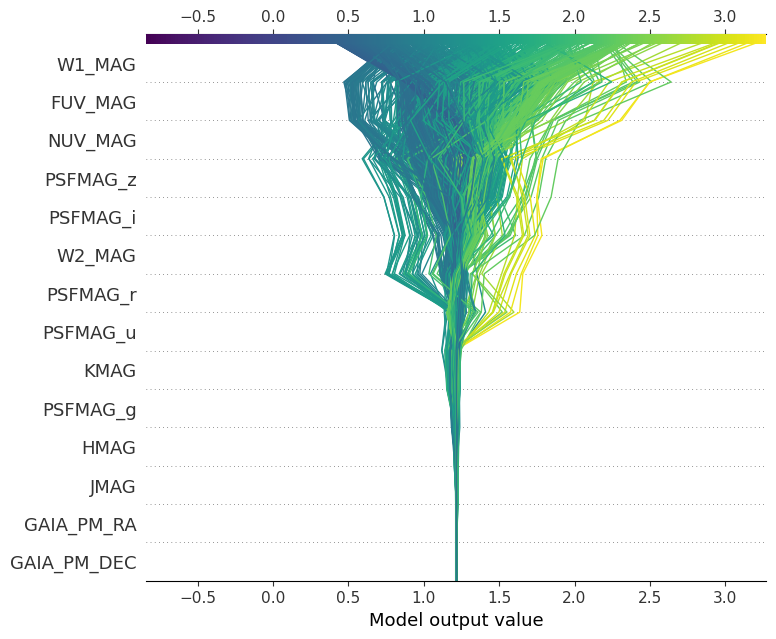

In [25]:
shap.decision_plot(explainer_SDSS.expected_value,
                    shap_values_SDSS,
                    X_test,
                    plot_color='viridis')

For clarity, we plot the first ten sources of the test subset. We can see that the source with the highest predicted redshift has a behaviour different from the rest. Its r and u magnitudes are different, making it an outlier in this sample. Is it worth investigating it further?

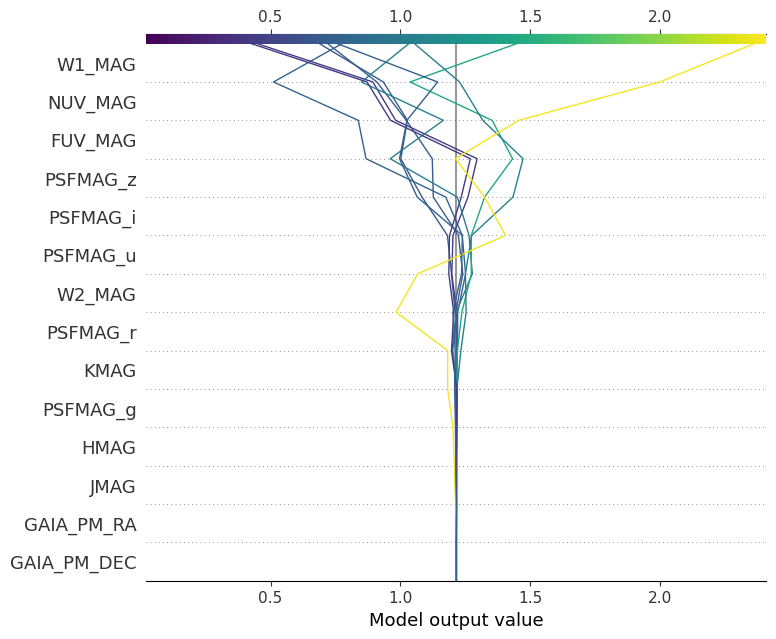

In [26]:
shap.decision_plot(explainer_SDSS.expected_value,
                    shap_values_SDSS[:10],
                    X_test.iloc[:10],
                    plot_color='viridis')

In conclusion, we can go beyond predictions with the use of feature importance methods. In particular, SHAP can help us obtaining very relevant information about the behaviour of the predicted elements inside models and functions. In Astrophysical contexts, we can use SHAP values to extract (hidden?) connections between features that can drive new discoveries.